# Autoregressors with Decision Trees

...

**Packages**

In [13]:
# !pip install xgboost

In [1]:
# basic packages
import numpy as np
import pandas as pd

import time
import datetime

# for graphs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

# save/load models
import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

In [2]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [3]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [4]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

**Load data**

In [5]:
train = pd.read_parquet('../data/03_train-test/train_data.parquet')
test = pd.read_parquet('../data/03_train-test/test_data.parquet')

In [6]:
train2 = pd.read_parquet('../data/03_train-test/summed_data_train.parquet')
test2 = pd.read_parquet('../data/03_train-test/summed_data_test.parquet')
test2 = test2[:365*2]

**Preparation of the data**

In [7]:
# set the index
train = train.set_index(['ds'])
test = test.set_index(['ds'])

# set the frequency
train = train.asfreq(freq='30min', fill_value=np.nan)
test = test.asfreq(freq='30min', fill_value=np.nan)

# fill nan-values
train = train.fillna(method='backfill')
test = test.fillna(method='backfill')

# conver to a Series object
train = train.squeeze()
test = test.squeeze()

In [8]:
# set the frequency
train2 = train2.asfreq(freq='D', fill_value=np.nan)
test2 = test2.asfreq(freq='D', fill_value=np.nan)

# fill nan-values
train2 = train2.fillna(method='backfill')
test2 = test2.fillna(method='backfill')

# conver to a Series object
train2 = train2.squeeze()
test2 = test2.squeeze()

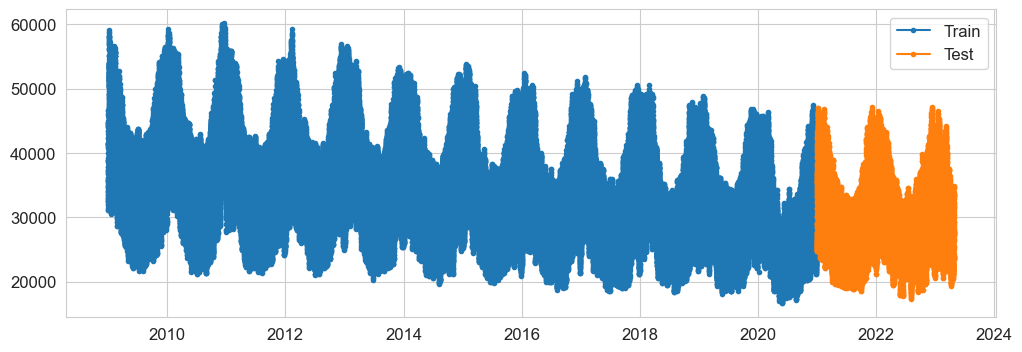

In [9]:
fig= plt.figure(figsize=(12,4))
plt.plot(train, marker='.', label='Train')
plt.plot(test, marker='.', label='Test')
plt.legend()

## Decision Trees
...

In [10]:
data = train.copy().to_frame()

In [11]:
for i in range(1,11):
    data['lag_{}'.format(i)] = data['y'].shift(i)

In [12]:
data = data.dropna()
data

y    lag_1    lag_2    lag_3    lag_4    lag_5  \
ds                                                                          
2009-01-01 05:00:00  33378.0  33934.0  34635.0  35678.0  36844.0  37135.0   
2009-01-01 05:30:00  32915.0  33378.0  33934.0  34635.0  35678.0  36844.0   
2009-01-01 06:00:00  32875.0  32915.0  33378.0  33934.0  34635.0  35678.0   
2009-01-01 06:30:00  32720.0  32875.0  32915.0  33378.0  33934.0  34635.0   
2009-01-01 07:00:00  31900.0  32720.0  32875.0  32915.0  33378.0  33934.0   
...                      ...      ...      ...      ...      ...      ...   
2020-12-31 21:30:00  32919.0  34358.0  35867.0  37018.0  38500.0  40112.0   
2020-12-31 22:00:00  31727.0  32919.0  34358.0  35867.0  37018.0  38500.0   
2020-12-31 22:30:00  30925.0  31727.0  32919.0  34358.0  35867.0  37018.0   
2020-12-31 23:00:00  30011.0  30925.0  31727.0  32919.0  34358.0  35867.0   
2020-12-31 23:30:00  29165.0  30011.0  30925.0  31727.0  32919.0  34358.0   

                       lag_6    lag_7    lag_8    lag_9   lag_10  
ds                                                                
2009-01-01 05:00:00  37298.0  37775.0  38651.0  38964.0  38704.0  
2009-01-01 05:30:00  37135.0  37298.0  37775.0  38651.0  38964.0  
2009-01-01 06:00:00  36844.0  37135.0  37298.0  37775.0  38651.0  
2009-01-01 06:30:00  35678.0  36844.0  37135.0  37298.0  37775.0  
2009-01-01 07:00:00  34635.0  35678.0  36844.0  37135.0  37298.0  
...                      ...      ...      ...      ...      ...  
2020-12-31 21:30:00  41531.0  42836.0  43232.0  43263.0  42489.0  
2020-12-31 22:00:00  40112.0  41531.0  42836.0  43232.0  43263.0  
2020-12-31 22:30:00  38500.0  40112.0  41531.0  42836.0  43232.0  
2020-12-31 23:00:00  37018.0  38500.0  40112.0  41531.0  42836.0  
2020-12-31 23:30:00  35867.0  37018.0  38500.0  40112.0  41531.0  

[210374 rows x 11 columns]

In [13]:
y = data['y']
X = data.drop('y', axis=1)

In [14]:
tree = DecisionTreeRegressor(max_depth=2, random_state=6)
tree.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=6)

[Text(0.5, 0.8333333333333334, 'lag_1 <= 34907.5\nsamples = 100.0%\nvalue = 33931.318'),
 Text(0.25, 0.5, 'lag_1 <= 28128.5\nsamples = 57.1%\nvalue = 28435.991'),
 Text(0.125, 0.16666666666666666, 'samples = 26.4%\nvalue = 24793.741'),
 Text(0.375, 0.16666666666666666, 'samples = 30.7%\nvalue = 31569.624'),
 Text(0.75, 0.5, 'lag_1 <= 42832.5\nsamples = 42.9%\nvalue = 41240.283'),
 Text(0.625, 0.16666666666666666, 'samples = 29.2%\nvalue = 38606.791'),
 Text(0.875, 0.16666666666666666, 'samples = 13.7%\nvalue = 46868.812')]

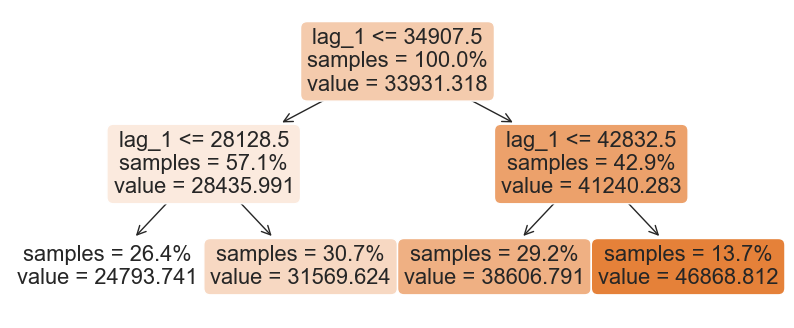

In [15]:
plt.figure(figsize = (10, 4))
plot_tree(tree, feature_names = X.columns, filled = True, impurity = False, proportion = True, rounded=True)
# plt.savefig("../graphs/reg_tree.png")

In [16]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': tree.feature_importances_}
)
importance.sort_values('importance', ascending=False, inplace=True)
importance

feature  importance
0   lag_1         1.0
1   lag_2         0.0
2   lag_3         0.0
3   lag_4         0.0
4   lag_5         0.0
5   lag_6         0.0
6   lag_7         0.0
7   lag_8         0.0
8   lag_9         0.0
9  lag_10         0.0

## Recursive multi-step forecasting 

...

In [18]:
R_RF1 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB1.pkl')) 
R_RF2 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB2.pkl')) 
R_XGB1 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB1.pkl')) 
R_XGB2 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB2.pkl')) 
R_XGB3 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB3.pkl')) 
R_XGB4 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB4.pkl')) 
R_XGB5 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB5.pkl')) 
R_XGB6 = joblib.load(project_path.joinpath('data/models/autoreg/R_XGB6.pkl')) 

In [11]:
steps = len(test)
steps2 = 365*2

### Random Forest

#### Model 1: Forecasting with the previous day

In [26]:
t1 = time.perf_counter()
R_RF1 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48)

R_RF1.fit(y=train) # fit the model
t2 = time.perf_counter()
R_RF_time1 = t2-t1

In [32]:
joblib.dump(D_RF1, project_path.joinpath('data/models/autoreg/D_RF1.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\autoreg\\D_RF1.pkl']

In [27]:
%%time
R_RF_pred1 = R_RF1.predict(steps=steps) # predict
R_RF_pred1.head(5)

Wall time: 2min 10s


2021-01-01 00:00:00    29123.8
2021-01-01 00:30:00    28987.7
2021-01-01 01:00:00    28674.3
2021-01-01 01:30:00    28224.2
2021-01-01 02:00:00    27958.2
Freq: 30T, Name: pred, dtype: float64

Text(0.5, 0, '')

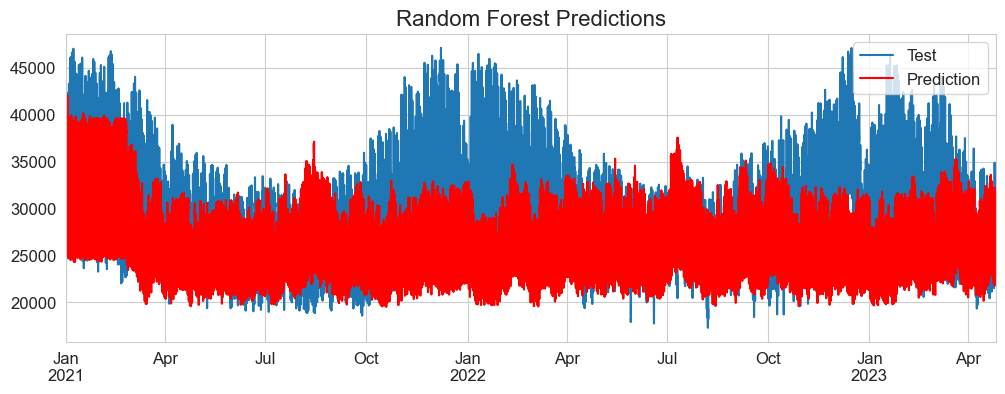

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_RF_pred1.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

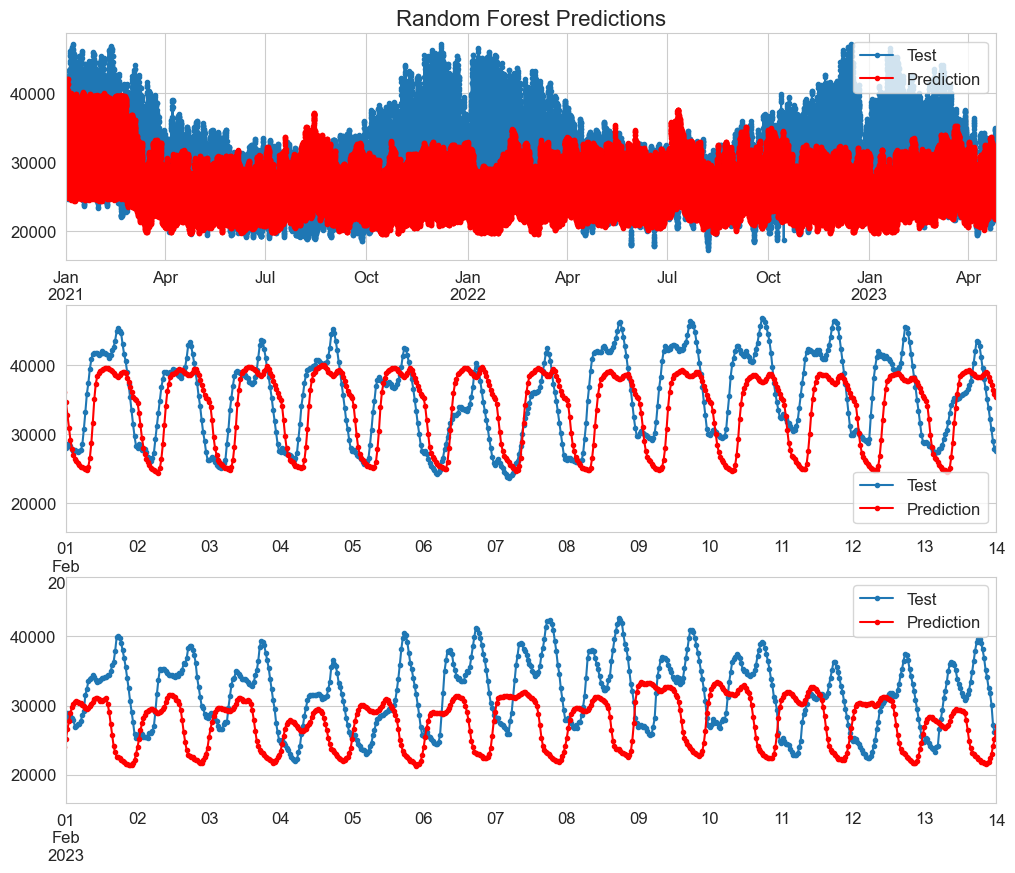

In [30]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
R_RF_pred1.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
R_RF_pred1.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
R_RF_pred1.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [31]:
R_RF_mse1  = mean_squared_error(y_true = test,y_pred = R_RF_pred1)
R_RF_mape1 = mean_absolute_percentage_error(y_true=test, y_pred=R_RF_pred1)

print('MAPE:', R_RF_mape1)
print('MSE: ', R_RF_mse1)

MAPE: 18.820462276578205
MSE:  50238635.61542955


#### Model 2: Forecasting with the previous week

In [28]:
t1 = time.perf_counter()
R_RF2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*7)

R_RF2.fit(y=train) # fit the model
t2 = time.perf_counter()
R_RF_time2 = t2-t1

In [33]:
%%time
R_RF_pred2 = R_RF2.predict(steps=steps) # predict

Wall time: 1min 54s


Text(0.5, 0, '')

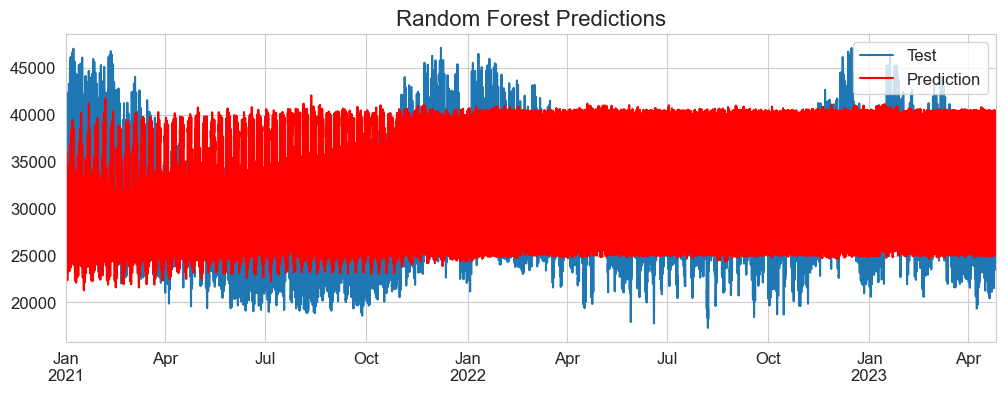

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_RF_pred2.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

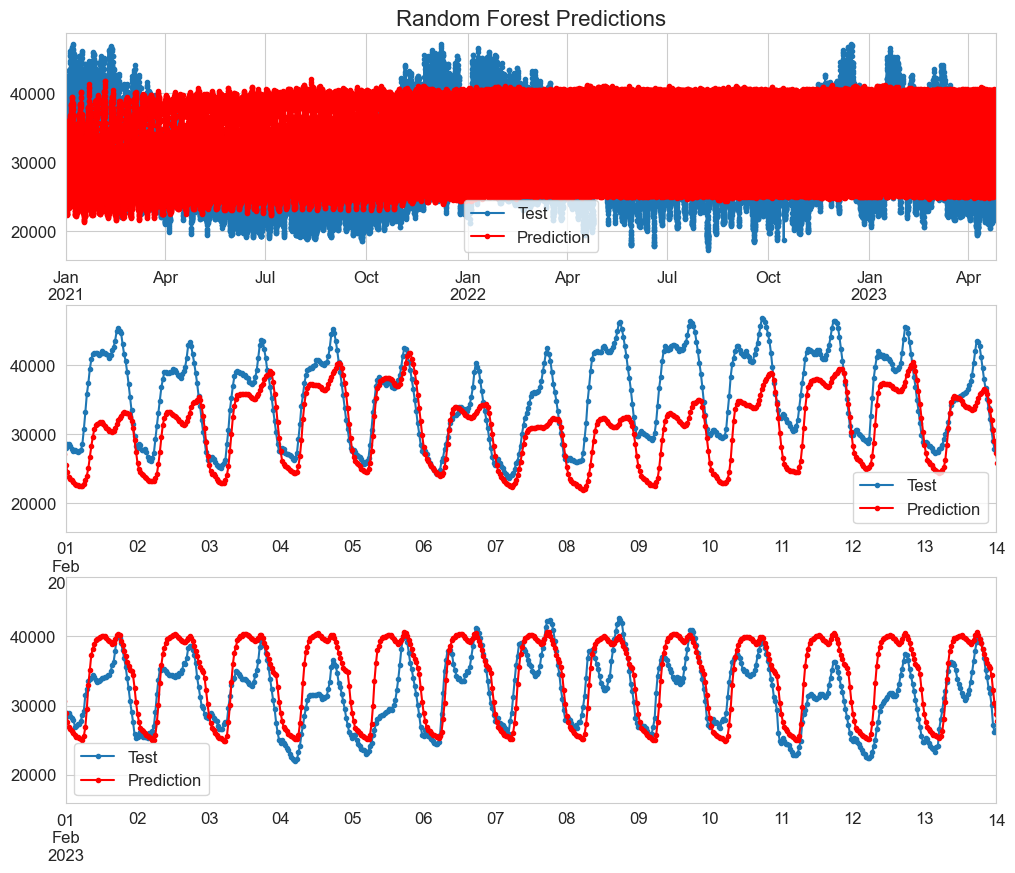

In [35]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
R_RF_pred2.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
R_RF_pred2.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
R_RF_pred2.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [36]:
R_RF_mse2  = mean_squared_error(y_true = test,y_pred = R_RF_pred2)
R_RF_mape2 = mean_absolute_percentage_error(y_true=test, y_pred=R_RF_pred2)

print('MAPE:', R_RF_mape2)
print('MSE: ', R_RF_mse2)

MAPE: 19.039458118657514
MSE:  44949987.36405498


#### Model 3: Forecasting with the previous month : too much time

#### Model 3: Daily data

In [42]:
t1 = time.perf_counter()
R_RF3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = steps2)

R_RF3.fit(y=train2) # fit the model
t2 = time.perf_counter()
R_RF_time3 = t2-t1

In [43]:
%%time
R_RF_pred3 = R_RF3.predict(steps=steps2) # predict
R_RF_pred3.head(5)

Wall time: 2.12 s


2021-01-01    1587692.6
2021-01-02    1409683.3
2021-01-03    1421416.1
2021-01-04    1494260.6
2021-01-05    1572059.6
Freq: D, Name: pred, dtype: float64

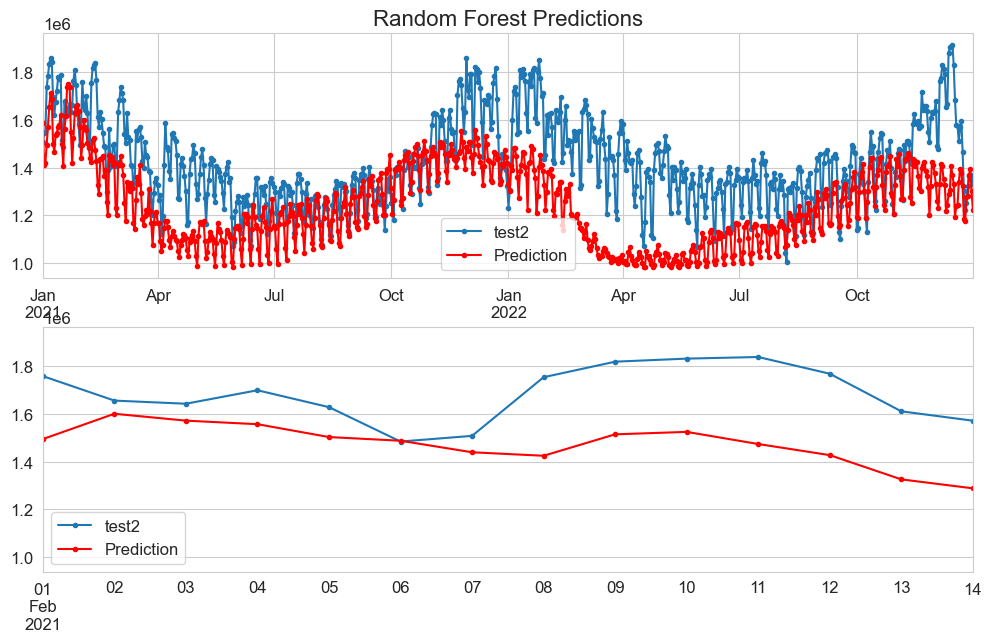

In [48]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(12, 7))

test2.plot(ax=ax, marker='.', label='test2')
R_RF_pred3.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test2.plot(ax=bx, marker='.', label='test2')
R_RF_pred3.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))


**Error**

In [49]:
R_RF_mse3  = mean_squared_error(y_true = test2,y_pred = R_RF_pred3)
R_RF_mape3 = mean_absolute_percentage_error(y_true=test2, y_pred=R_RF_pred3)

print('MAPE:', R_RF_mape3)
print('MSE: ', R_RF_mse3)

MAPE: 13.10425975715195
MSE:  54230646998.3403


### XGBoost

#### Model 1: Forecasting with the previous day

In [41]:
t1 = time.perf_counter()
R_XGB1 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, max_depth=5),
                lags = 48)

R_XGB1.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time1 = t2-t1

In [50]:
%%time
R_XGB_pred1 = R_XGB1.predict(steps=steps) # predict

Wall time: 3min 11s


Text(0.5, 0, '')

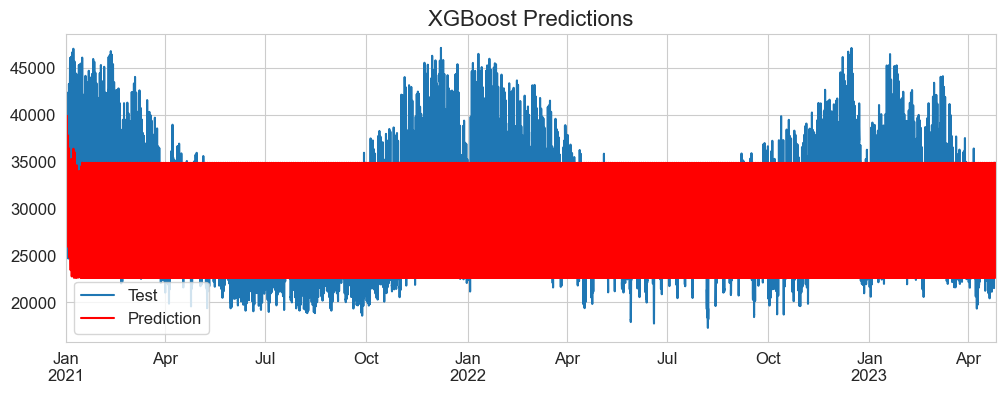

In [51]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_XGB_pred1.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

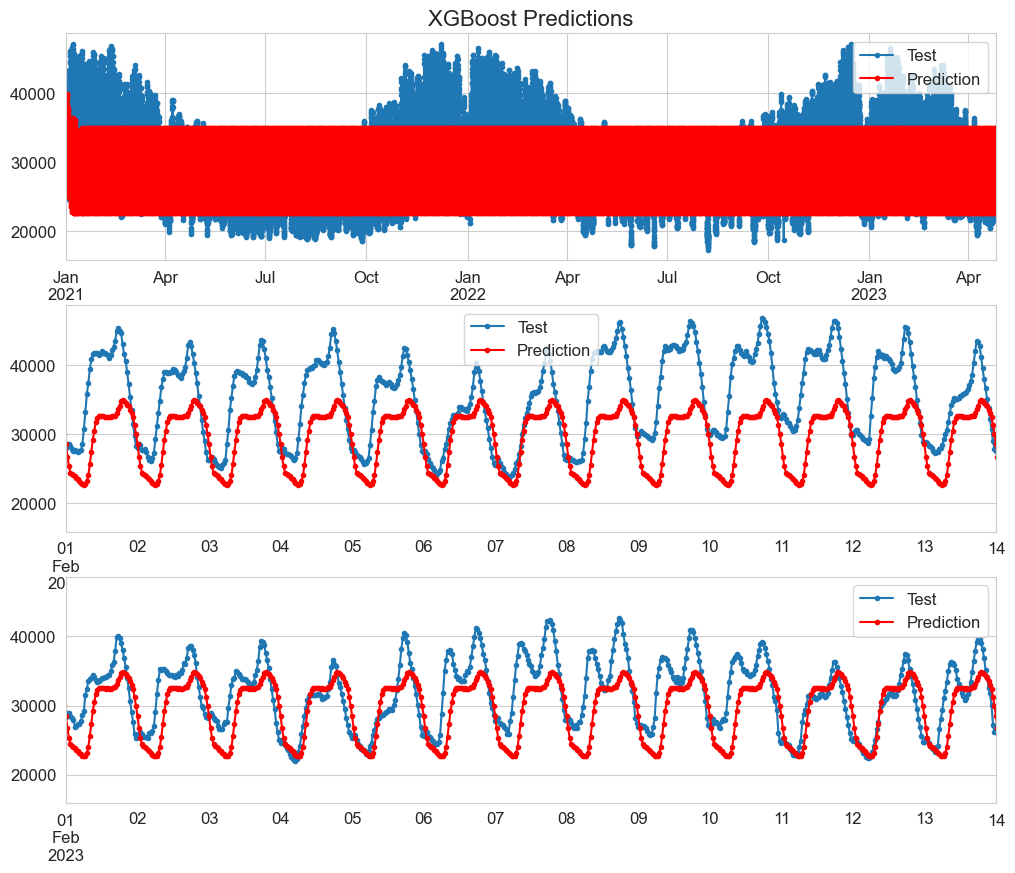

In [52]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
R_XGB_pred1.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
R_XGB_pred1.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
R_XGB_pred1.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [53]:
R_XGB_mse1  = mean_squared_error(y_true = test,y_pred = R_XGB_pred1)
R_XGB_mape1 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred1)

print('MAPE:', R_XGB_mape1)
print('MSE: ', R_XGB_mse1)

MAPE: 13.128790020560485
MSE:  24235647.84642631


#### Model 2: Forecasting with the previous week

In [46]:
t1 = time.perf_counter()
R_XGB2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*7)

R_XGB2.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time2 = t2-t1

In [54]:
%%time
R_XGB_pred2 = R_XGB2.predict(steps=steps) # predict

Wall time: 1min 54s


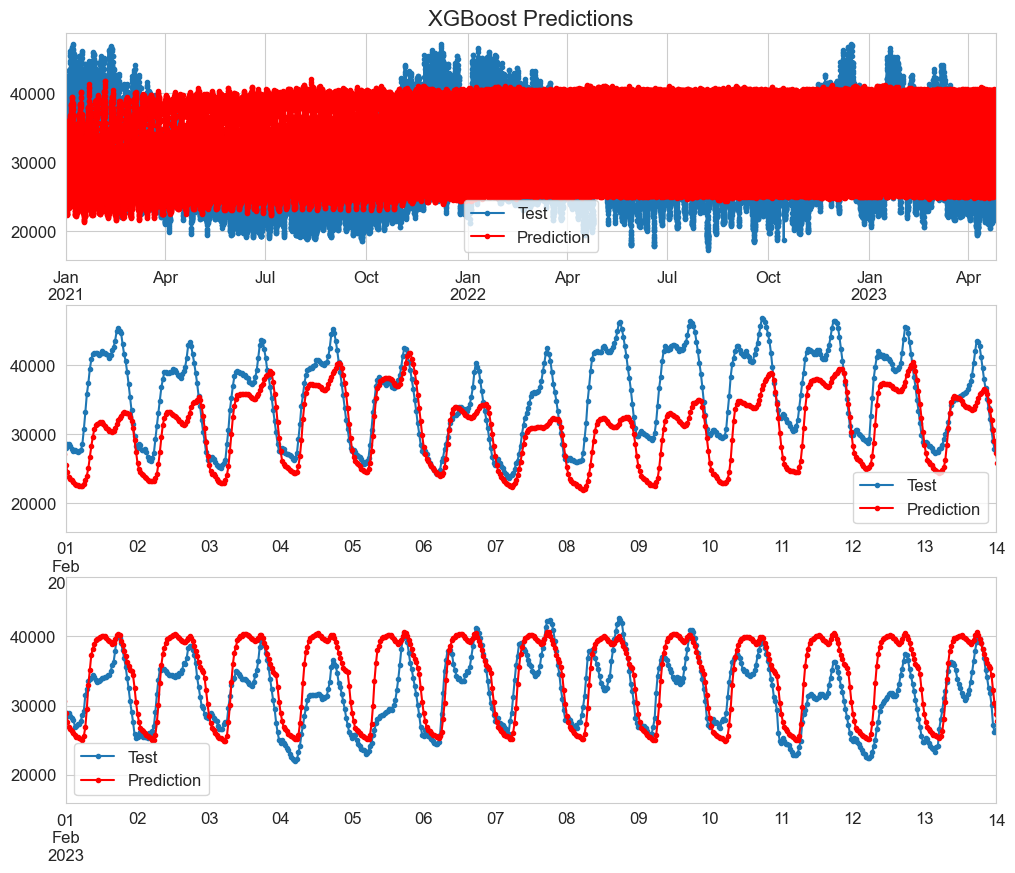

In [55]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
R_XGB_pred2.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
R_XGB_pred2.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
R_XGB_pred2.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [56]:
R_XGB_mse2  = mean_squared_error(y_true = test,y_pred = R_XGB_pred2)
R_XGB_mape2 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred2)

print('MAPE:', R_XGB_mape2)
print('MSE: ', R_XGB_mse2)

MAPE: 19.039458118657514
MSE:  44949987.36405498


#### Model 3: Forecasting with the previous month

In [51]:
t1 = time.perf_counter()
R_XGB3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*30)

R_XGB3.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time3 = t2-t1

In [57]:
%%time
R_XGB_pred3 = R_XGB3.predict(steps=steps) # predict

Wall time: 1min 54s


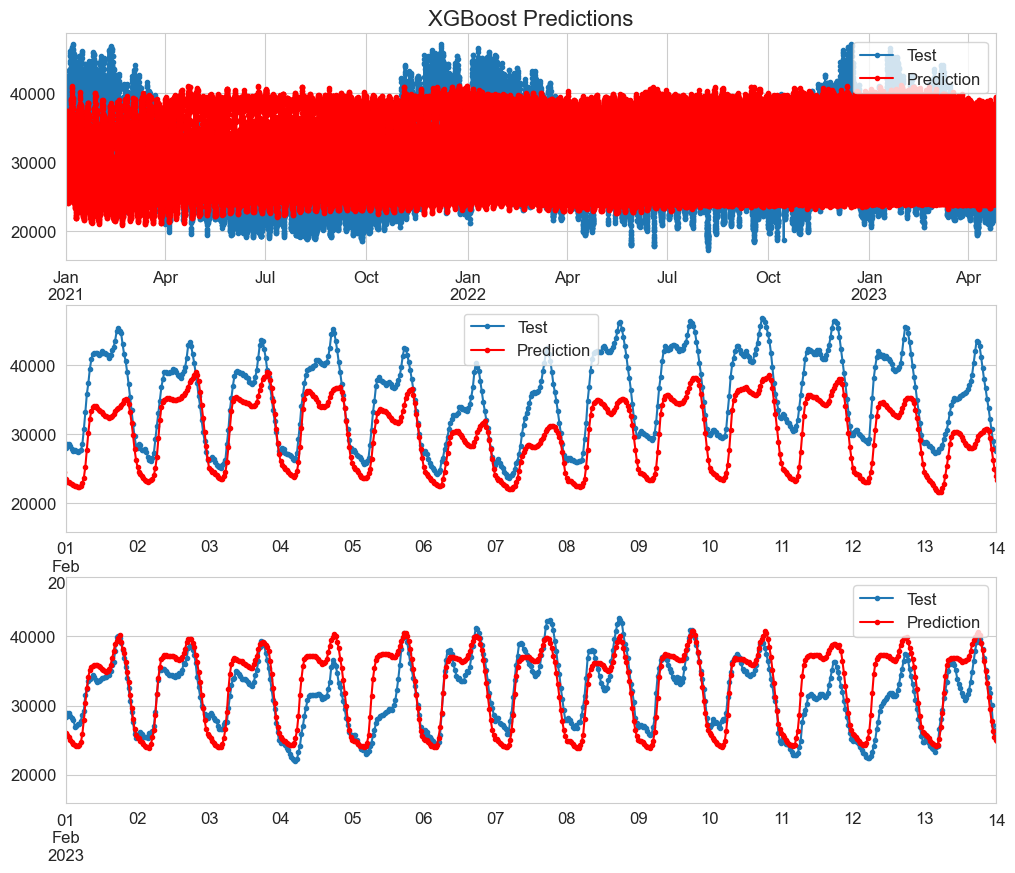

In [58]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
R_XGB_pred3.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
R_XGB_pred3.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
R_XGB_pred3.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

plt.savefig("../graphs/XGBoost.png")

**Error**

In [59]:
R_XGB_mse3  = mean_squared_error(y_true = test,y_pred = R_XGB_pred3)
R_XGB_mape3 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred3)

print('MAPE:', R_XGB_mape3)
print('MSE: ', R_XGB_mse3)

MAPE: 14.975039694289322
MSE:  29374728.671074945


#### Model 4-5-6: Tunning - Changing learning_rate

In [65]:
%%time
t1 = time.perf_counter()
R_XGB4 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.1),
                lags = 48*7)

R_XGB4.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time4 = t2-t1

Wall time: 3min 16s


In [60]:
%%time
R_XGB_pred4 = R_XGB4.predict(steps=steps) # predict

Wall time: 4min 11s


Text(0.5, 0, '')

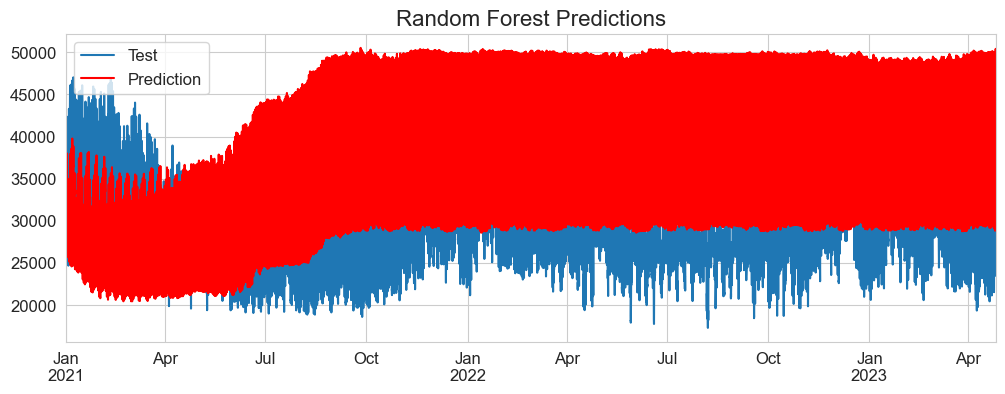

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_XGB_pred4.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

In [82]:
%%time
t1 = time.perf_counter()
R_XGB5 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.2),
                lags = 48*30)

R_XGB5.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time5 = t2-t1

Wall time: 26min 43s


In [13]:
%%time
R_XGB_pred5 = R_XGB5.predict(steps=steps) # predict

Wall time: 1min 7s


Text(0.5, 0, '')

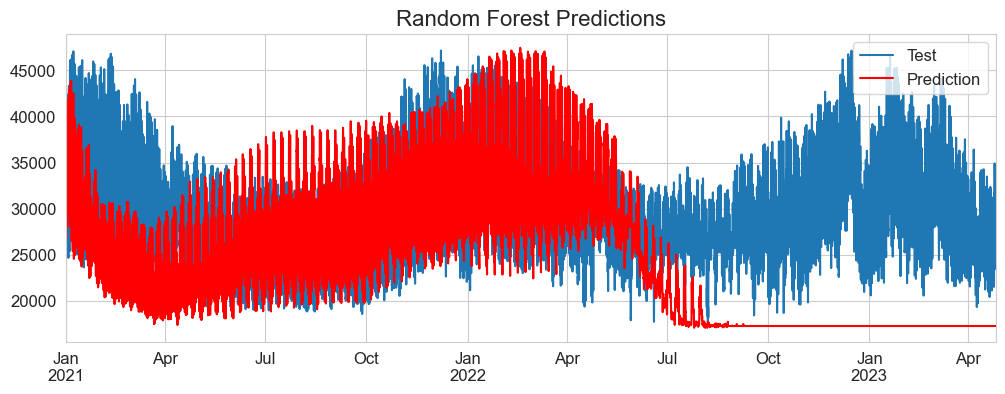

In [84]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_XGB_pred5.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

In [103]:
%%time
t1 = time.perf_counter()
R_XGB6 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.25),
                lags = 48*30)

R_XGB6.fit(y=train) # fit the model
t2 = time.perf_counter()
R_XGB_time6 = t2-t1

Wall time: 14min 49s


In [12]:
%%time
R_XGB_pred6 = R_XGB6.predict(steps=steps) # predict

Wall time: 55.2 s


Text(0.5, 0, '')

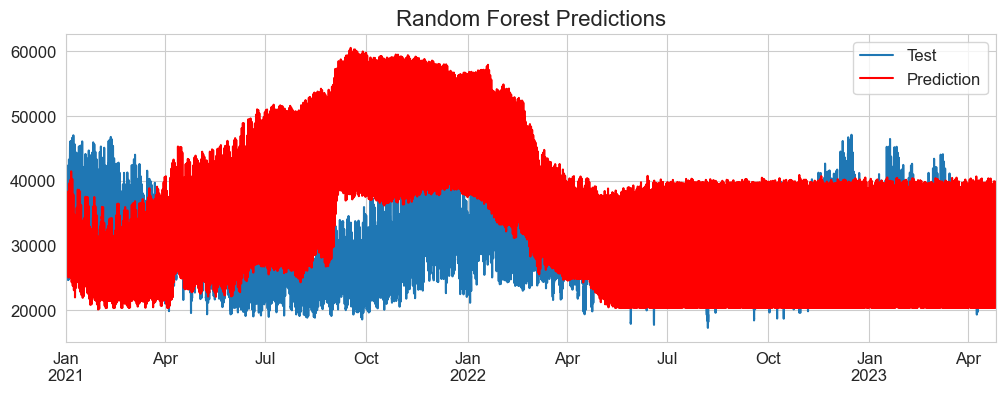

In [105]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
R_XGB_pred6.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

**Error**

In [62]:
R_XGB_mse4  = mean_squared_error(y_true = test,y_pred = R_XGB_pred4)
R_XGB_mape4 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred4)

print('MAPE:', R_XGB_mape4)
print('MSE: ', R_XGB_mse4)

MAPE: 28.174376607223717
MSE:  90180445.10429119


In [115]:
R_XGB_mse6  = mean_squared_error(y_true = test,y_pred = R_XGB_pred6)
R_XGB_mape6 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred6)

print('MAPE:', R_XGB_mape6)
print('MSE: ', R_XGB_mse6)

MAPE: 25.065947356121754
MSE:  91052095.98077756


In [116]:
R_XGB_mse7  = mean_squared_error(y_true = test,y_pred = R_XGB_pred7)
R_XGB_mape7 = mean_absolute_percentage_error(y_true=test, y_pred=R_XGB_pred7)

print('MAPE:', R_XGB_mape7)
print('MSE: ', R_XGB_mse7)

MAPE: 35.120758966605685
MSE:  145810770.47574413


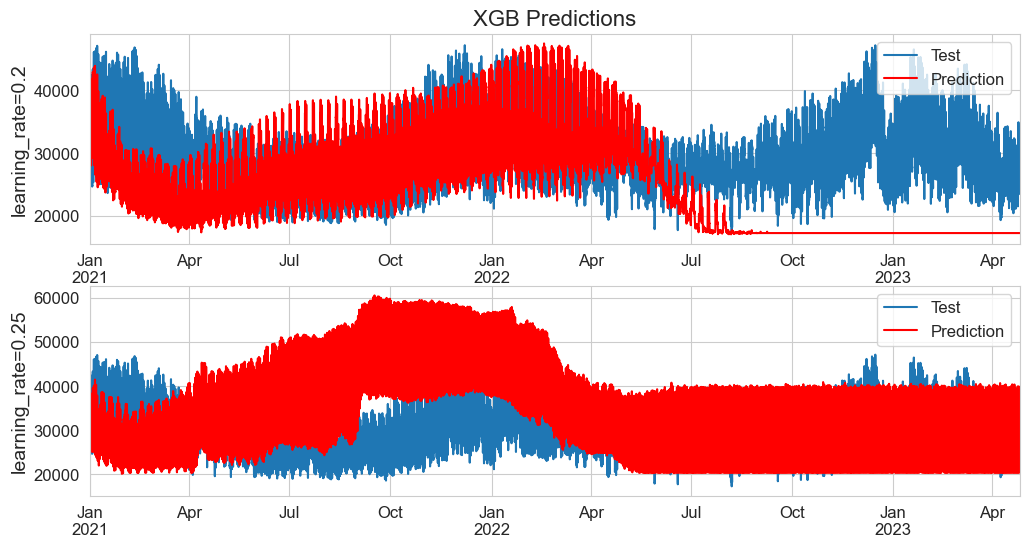

In [15]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(12, 6))
test.plot(ax=ax, label='Test')
R_XGB_pred5.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('R_XGB Predictions')
ax.set_xlabel('')
ax.set_ylabel('learning_rate=0.2')

test.plot(ax=bx, label='Test')
R_XGB_pred6.plot(ax=bx, label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_ylabel('learning_rate=0.25')
plt.savefig("../graphs/XGBoost_adjust.png")

**Results**

In [119]:
x = ['R_RF1', 'R_RF2', 'R_XGB1', 'R_XGB2', 'R_XGB3', 'R_XGB4', 'R_XGB5', 'R_XGB6']
y1 = [R_RF_mape1, R_RF_mape2, R_XGB_mape1, R_XGB_mape2, R_XGB_mape3, R_XGB_mape4, R_XGB_mape5, R_XGB_mape6]
y2 = [R_RF_mse1, R_RF_mse2, R_XGB_mse1, R_XGB_mse2, R_XGB_mse3, R_XGB_mse4, R_XGB_mse5, R_XGB_mse6]
y3 = [R_RF_time1, R_RF_time2, R_XGB_time1, R_XGB_time2, R_XGB_time3, R_XGB_time4, R_XGB_time5, R_XGB_time6]

In [129]:
df = pd.DataFrame([y1,y2, y3], columns=x, index=['MAPE', 'MSE', 'Time'])
df = df.T
df

MAPE           MSE         Time
RF1   18.820462  5.023864e+07    96.238158
RF2   19.039458  4.494999e+07   635.349198
XGB1  13.128790  2.423565e+07    17.304973
XGB2  19.039458  4.494999e+07   623.785312
XGB3  14.975040  2.937473e+07  2821.581039
XGB4  28.174377  9.018045e+07   196.213466
XGB6  25.065947  9.105210e+07  1608.645877
XGB7  35.120759  1.458108e+08   889.468546

In [132]:
df.to_csv('../data/results/autoreg.csv')

#### Save the models

In [62]:
joblib.dump(R_RF1, project_path.joinpath('data/models/autoreg/R_RF1.pkl'))
joblib.dump(R_RF2, project_path.joinpath('data/models/autoreg/R_RF2.pkl'))
joblib.dump(R_XGB1, project_path.joinpath('data/models/autoreg/R_XGB1.pkl'))
joblib.dump(R_XGB2, project_path.joinpath('data/models/autoreg/R_XGB2.pkl'))
joblib.dump(R_XGB3, project_path.joinpath('data/models/autoreg/R_XGB3.pkl'))
joblib.dump(R_XGB4, project_path.joinpath('data/models/autoreg/R_XGB4.pkl'))
joblib.dump(R_XGB5, project_path.joinpath('data/models/autoreg/R_XGB5.pkl'))
joblib.dump(R_XGB6, project_path.joinpath('data/models/autoreg/R_XGB6.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\autoreg\\XGB3.pkl']

#### Importance of the lags 

In [151]:
result = R_XGB3.get_feature_importances()
result.sort_values('importance', ascending=False)

feature    importance
0        lag_1  9.814392e-01
2        lag_3  4.002060e-03
332    lag_333  2.433653e-03
333    lag_334  2.240072e-03
1        lag_2  1.543412e-03
...        ...           ...
557    lag_558  7.017989e-07
1131  lag_1132  6.926963e-07
797    lag_798  6.722746e-07
938    lag_939  6.691278e-07
1228  lag_1229  6.430357e-07

[1440 rows x 2 columns]

In [153]:
result2 = R_XGB7.get_feature_importances()
result2.sort_values('importance', ascending=False)

feature  importance
0      lag_1    0.700984
333  lag_334    0.015709
668  lag_669    0.013187
2      lag_3    0.010674
332  lag_333    0.009673
..       ...         ...
918  lag_919    0.000000
917  lag_918    0.000000
502  lag_503    0.000000
509  lag_510    0.000000
859  lag_860    0.000000

[1440 rows x 2 columns]

## Direct multi-step forecasting 

...

In [9]:
D_RF1 = joblib.load(project_path.joinpath('data/models/autoreg/D_RF1.pkl')) 
D_RF2 = joblib.load(project_path.joinpath('data/models/autoreg/D_RF2.pkl')) 
D_RF3 = joblib.load(project_path.joinpath('data/models/autoreg/D_RF3.pkl')) 
D_XGB1 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB1.pkl')) 
D_XGB2 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB2.pkl')) 
D_XGB3 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB3.pkl')) 

### Random Forest

In [ ]:
joblib.dump(D_RF2, project_path.joinpath('data/models/autoreg/D_RF2.pkl'))

#### Model 1: Forecasting with the previous week

In [20]:
t1 = time.perf_counter()
D_RF1 = ForecasterAutoregDirect(
                regressor     = RandomForestRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 7)
D_RF1.fit(y=train2) # fit the model
t2 = time.perf_counter()
RF_time1 = t2-t1

In [35]:
RF_time1

139.6772484999999

In [21]:
%%time
RF_predD1 = D_RF1.predict(steps=steps2) # predict
RF_predD1.head(5)

Wall time: 656 ms


2021-01-01    1498025.9
2021-01-02    1380287.8
2021-01-03    1330691.8
2021-01-04    1528025.2
2021-01-05    1674325.8
Name: pred, dtype: float64

Text(0.5, 0, '')

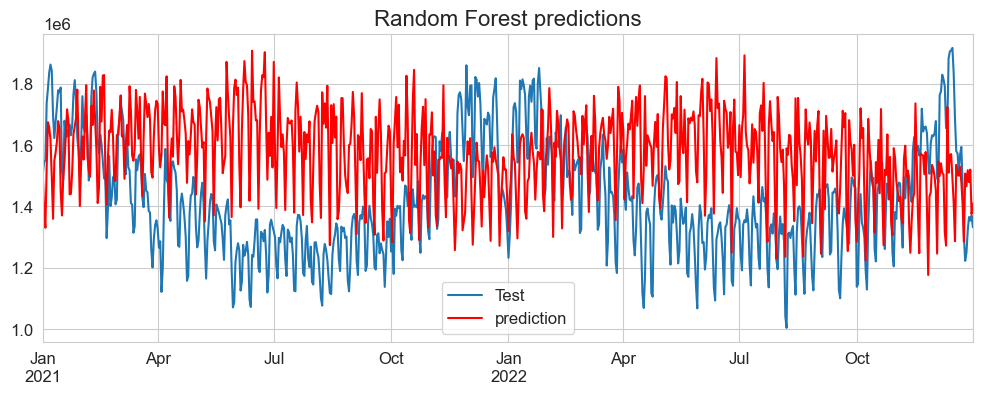

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
RF_predD1.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('Random Forest predictions')
ax.set_xlabel('')

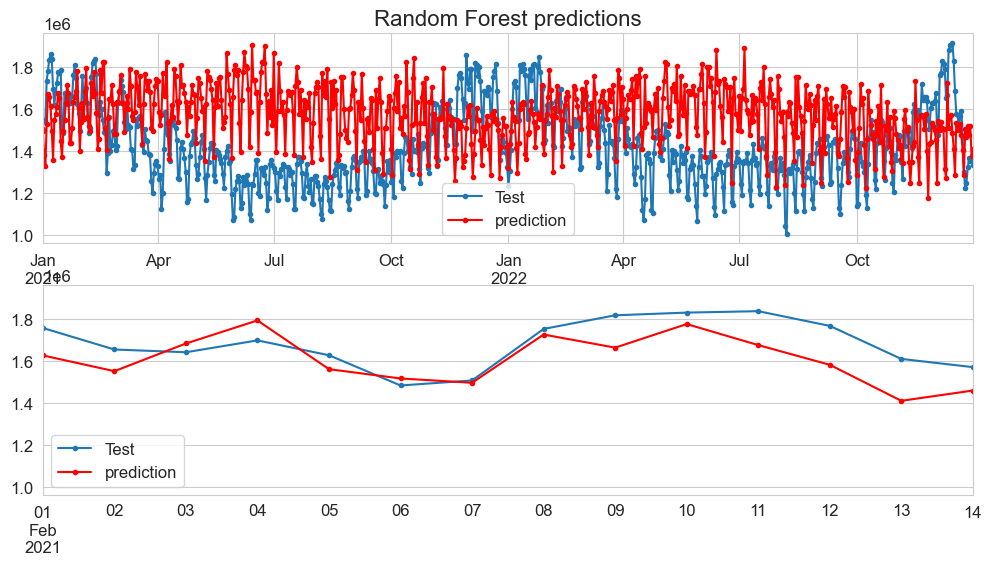

In [23]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(12, 6))

test2.plot(ax=ax, marker='.', label='Test')
RF_predD1.plot(ax=ax, marker='.', label='prediction', color='r')
ax.legend()
ax.set_title('Random Forest predictions')
ax.set_xlabel('')

test2.plot(ax=bx, marker='.', label='Test')
RF_predD1.plot(ax=bx, marker='.', label='prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

**Error**

In [24]:
RF_mse1  = mean_squared_error(y_true = test2,y_pred = RF_predD1)
RF_mape1 = mean_absolute_percentage_error(y_true=test2, y_pred=RF_predD1)

print('MAPE:', RF_mape1)
print('MSE: ', RF_mse1)

MAPE: 17.0202809293907
MSE:  74110663204.3714


#### Model 2: Forecasting with the previous week

In [ ]:
t1 = time.perf_counter()
D_RF2 = ForecasterAutoregDirect(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 30)

D_RF2.fit(y=train2) # fit the model
t2 = time.perf_counter()
RF_time2 = t2-t1

In [45]:
%%time
RF_predD2 = D_RF2.predict(steps=steps2) # predict

Wall time: 580 ms


Text(0.5, 0, '')

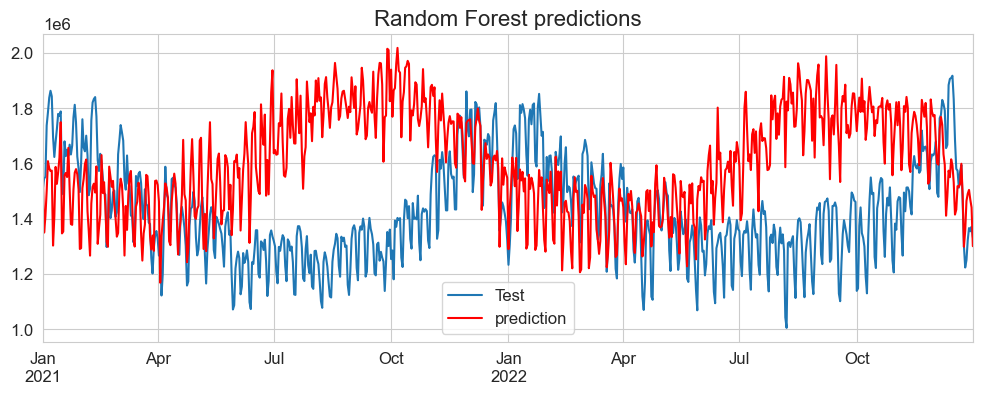

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
RF_predD2.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('Random Forest predictions')
ax.set_xlabel('')

In [68]:
RF_mse2  = mean_squared_error(y_true = test2,y_pred = RF_predD2)
RF_mape2 = mean_absolute_percentage_error(y_true=test2, y_pred=RF_predD2)

print('MAPE:', RF_mape2)
print('MSE: ', RF_mse2)

MAPE: 19.60879491960201
MSE:  103915973010.72093


#### Model 3: Forecasting with the previous year

In [12]:
t1 = time.perf_counter()
D_RF3 = ForecasterAutoregDirect(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 365)

D_RF3.fit(y=train2) # fit the model
t2 = time.perf_counter()
RF_time3 = t2-t1

In [19]:
RF_time3

8467.682626

In [28]:
%%time
RF_predD3 = D_RF3.predict(steps=steps2) # predict

Wall time: 599 ms


Text(0.5, 0, '')

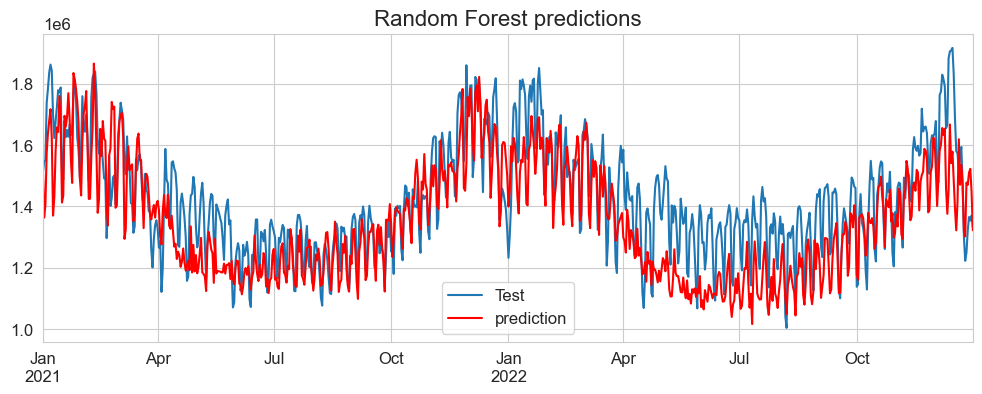

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
RF_predD3.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('Random Forest predictions')
ax.set_xlabel('')

In [30]:
RF_mse3  = mean_squared_error(y_true = test2[:365*2],y_pred = RF_predD3)
RF_mape3 = mean_absolute_percentage_error(y_true=test2[:365*2], y_pred=RF_predD3)

print('MAPE:', RF_mape3)
print('MSE: ', RF_mse3)

MAPE: 7.349203739049641
MSE:  17334656405.1729


### XGBoost

#### Model 1: Forecasting with the previous week

In [48]:
t1 = time.perf_counter()
D_XGB1 = ForecasterAutoregDirect(
                regressor     = XGBRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 7)

D_XGB1.fit(y=train2) # fit the model
t2 = time.perf_counter()
XGB_time1 = t2-t1

In [31]:
%%time
XGB_predD1 = D_XGB1.predict(steps=steps2) # predict

Wall time: 1.07 s


Text(0.5, 0, '')

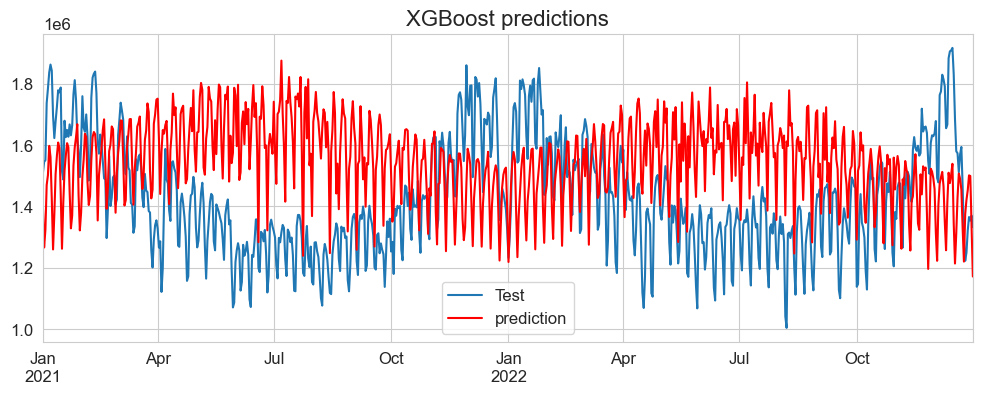

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
XGB_predD1.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('XGBoost predictions')
ax.set_xlabel('')

In [33]:
XGB_mse1  = mean_squared_error(y_true = test2,y_pred = XGB_predD1)
XGB_mape1 = mean_absolute_percentage_error(y_true=test2, y_pred=XGB_predD1)

print('MAPE:', XGB_mape1)
print('MSE: ', XGB_mse1)

MAPE: 16.695658880024418
MSE:  70423881797.9


#### Model 2: Forecasting with the previous month

In [53]:
t1 = time.perf_counter()
D_XGB2 = ForecasterAutoregDirect(
                regressor     = XGBRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 30)

D_XGB2.fit(y=train2) # fit the model
t2 = time.perf_counter()
XGB_time2 = t2-t1

In [37]:
%%time
XGB_predD2 = D_XGB2.predict(steps=steps2) # predict

Wall time: 1.12 s


Text(0.5, 0, '')

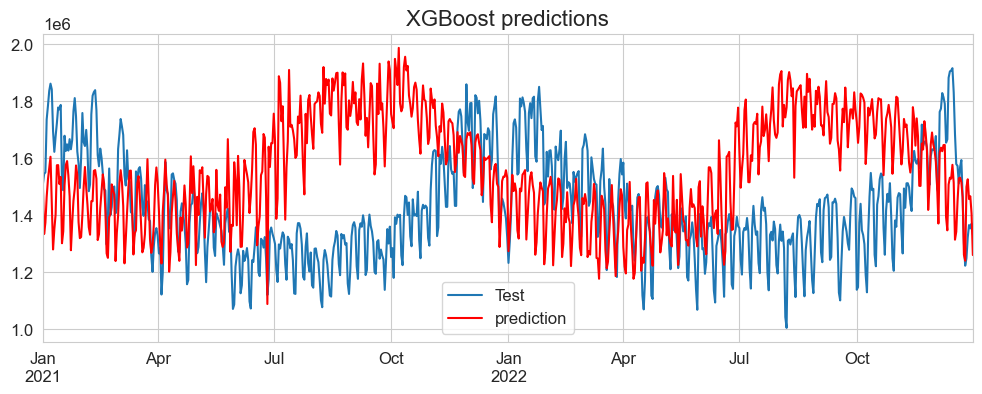

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
XGB_predD2.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('XGBoost predictions')
ax.set_xlabel('')

**Error**

In [39]:
XGB_mse2  = mean_squared_error(y_true = test2,y_pred = XGB_predD2)
XGB_mape2 = mean_absolute_percentage_error(y_true=test2, y_pred=XGB_predD2)

print('MAPE:', XGB_mape2)
print('MSE: ', XGB_mse2)

MAPE: 18.244796163157634
MSE:  91567293002.57697


#### Model 3: Forecasting with the previous year

In [62]:
t1 = time.perf_counter()
D_XGB3 = ForecasterAutoregDirect(
                regressor     = XGBRegressor(random_state=123, n_estimators=10),
                steps         = steps2,
                lags          = 365)

D_XGB3.fit(y=train2) # fit the model
t2 = time.perf_counter()
XGB_time3 = t2-t1

In [40]:
%%time
XGB_predD3 = D_XGB3.predict(steps=steps2) # predict

Wall time: 1.31 s


Text(0.5, 0, '')

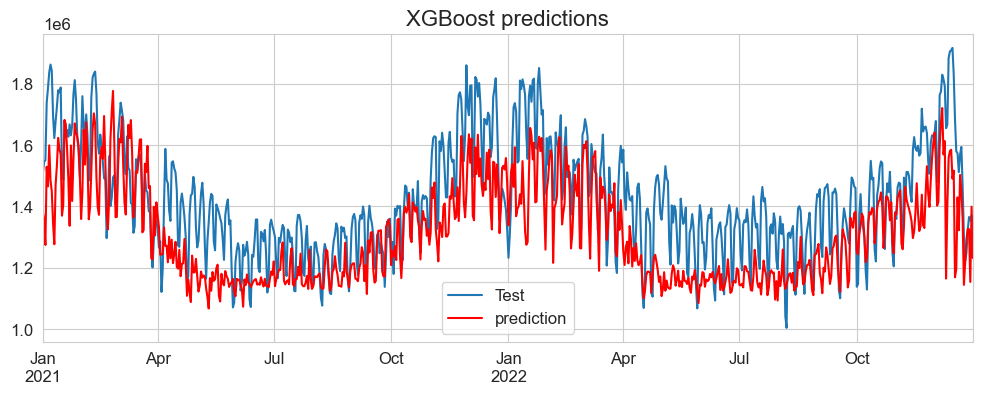

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
test2.plot(ax=ax, label='Test')
XGB_predD3.plot(ax=ax, label='prediction', color='r')
ax.legend()
ax.set_title('XGBoost predictions')
ax.set_xlabel('')

**Error**

In [42]:
XGB_mse3  = mean_squared_error(y_true = test2,y_pred = XGB_predD3)
XGB_mape3 = mean_absolute_percentage_error(y_true=test2, y_pred=XGB_predD3)

print('MAPE:', XGB_mape3)
print('MSE: ', XGB_mse3)

MAPE: 8.978467846123179
MSE:  26207242853.932255


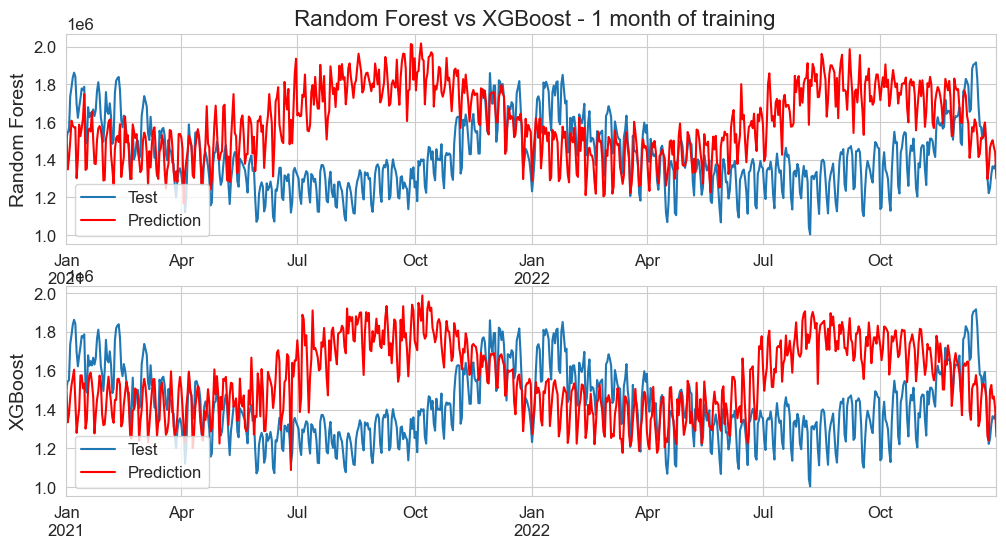

In [50]:
fig, (ax, bx) = plt.subplots(2,1, figsize=(12, 6))
test2.plot(ax=ax, label='Test')
RF_predD2.plot(ax=ax, label='Prediction', color='r')
ax.set_title(' Random Forest vs XGBoost - 1 month of training')
ax.legend(loc='lower left')
ax.set_ylabel('Random Forest')
ax.set_xlabel('')

test2.plot(ax=bx, label='Test')
XGB_predD2.plot(ax=bx, label='Prediction', color='r')
bx.legend(loc='lower left')
bx.set_ylabel('XGBoost')
bx.set_xlabel('')
plt.savefig("../graphs/autoreg_direct1.png")

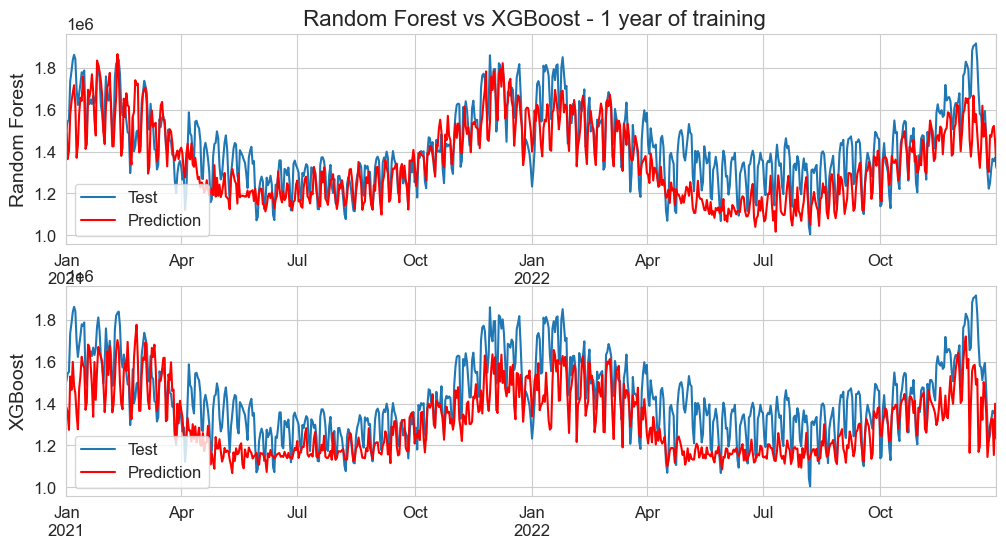

In [49]:
fig, (ax, bx) = plt.subplots(2,1, figsize=(12, 6))
test2.plot(ax=ax, label='Test')
RF_predD3.plot(ax=ax, label='Prediction', color='r')
ax.set_title(' Random Forest vs XGBoost - 1 year of training')
ax.legend(loc='lower left')
ax.set_ylabel('Random Forest')
ax.set_xlabel('')

test2.plot(ax=bx, label='Test')
XGB_predD3.plot(ax=bx, label='Prediction', color='r')
bx.legend(loc='lower left')
bx.set_ylabel('XGBoost')
bx.set_xlabel('')
plt.savefig("../graphs/autoreg_direct2.png")

**Results**

In [86]:
x = ['D_RF1', 'D_RF2', 'D_XGB1', 'D_XGB2', 'D_XGB3']
y1 = [RF_mape1, RF_mape2, XGB_mape1, XGB_mape2, XGB_mape3]
y2 = [RF_mse1, RF_mse2, XGB_mse1, XGB_mse2]
y3 = [RF_time1, RF_time2, XGB_time1, XGB_time2, XGB_time3]

In [ ]:
df = pd.DataFrame([y1,y2, y3], columns=x, index=['MAPE', 'MSE', 'Time'])
df = df.T
df

In [32]:
df = pd.DataFrame([y1,y2, y3], columns=x, index=['MAPE', 'MSE', 'Time'])
df = df.T
df

MAPE           MSE         Time
Unnamed: 0                                      
RF1         16.663398  7.297701e+10   139.677248
RF2         18.275184  9.441092e+10   565.869838
XGB1        15.876258  6.558727e+10    26.978365
XGB2        17.143311  8.388561e+10   173.220752
XGB3         9.876092  3.200124e+10  1217.609436

#### Save the models

In [90]:
joblib.dump(D_RF1, project_path.joinpath('data/models/autoreg/D_RF1.pkl'))
joblib.dump(D_RF2, project_path.joinpath('data/models/autoreg/D_RF2.pkl'))
joblib.dump(D_RF3, project_path.joinpath('data/models/autoreg/D_RF3.pkl'))
joblib.dump(D_XGB1, project_path.joinpath('data/models/autoreg/D_XGB1.pkl'))
joblib.dump(D_XGB2, project_path.joinpath('data/models/autoreg/D_XGB2.pkl'))
joblib.dump(D_XGB3, project_path.joinpath('data/models/autoreg/D_XGB3.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\autoreg\\D_XGB3.pkl']

In [8]:
D_RF1 = joblib.load(project_path.joinpath('data/models/autoreg/D_RF1.pkl')) 
D_RF2 = joblib.load(project_path.joinpath('data/models/autoreg/D_RF2.pkl')) 
D_XGB1 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB1.pkl')) 
D_XGB2 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB2.pkl')) 
D_XGB3 = joblib.load(project_path.joinpath('data/models/autoreg/D_XGB3.pkl')) 